# Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud

## Funções definidas

In [2]:
def ler_csv(caminho):
    with open(caminho, encoding="utf8", errors="ignore") as f:
        return pd.read_csv(f, sep=";")

def mudarvalor(coluna):
    for index in range(0, coluna.nunique()):
        coluna.replace(coluna.unique()[index], index, inplace=True)

def minmax_norm(df_input):
    return (df_input - df_input.min()) / (df_input.max() - df_input.min())


def agrupar(df, coluna, grupo, sort, drop):
    g = df[df[coluna] == grupo].sort_values(
        sort, ascending=False)
    g.drop(drop, axis=1, inplace=True)
    return g


def wc(df):
    d = {}
    for row in range(0, len(df)):
        d.update({df.index[row]: df.TP_APLIC[row]})
    return d


def agruparwc(df):
    g = df.groupby(['TP_ATIVO']).count()
    g.drop('VL_MERC_POS_FINAL', axis=1, inplace=True)
    g.sort_values('TP_APLIC', inplace=True, ascending=False)
    return g


# Arquivos

Importação dos arquivos e concatenação dos datasets em um único conjunto de dados

In [3]:
paths = ['dados\cda_fi_BLC_1_202112.csv',
         'dados\cda_fi_BLC_2_202112.csv',
         'dados\cda_fi_BLC_3_202112.csv',
         'dados\cda_fi_BLC_4_202112.csv',
         'dados\cda_fi_BLC_5_202112.csv',
         'dados\cda_fi_BLC_6_202112.csv',
         'dados\cda_fi_BLC_7_202112.csv',
         'dados\cda_fi_BLC_8_202112.csv',
         'dados\cda_fi_CONFID_202112.csv',
         'dados\cda_fi_PL_202112.csv']

In [4]:
fundo0 = ler_csv(paths[0])
fundo1 = ler_csv(paths[1])
fundo2 = ler_csv(paths[2])
fundo3 = ler_csv(paths[3])
fundo4 = ler_csv(paths[4])
fundo5 = ler_csv(paths[5])
fundo6 = ler_csv(paths[6])
fundo7 = ler_csv(paths[7])
fundo8 = ler_csv(paths[8])
fundo9 = ler_csv(paths[9])

<ipython-input-4-1c903f831f0c>:2: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  fundo1 = ler_csv(paths[1])
<ipython-input-4-1c903f831f0c>:4: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  fundo3 = ler_csv(paths[3])
<ipython-input-4-1c903f831f0c>:8: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  fundo7 = ler_csv(paths[7])


In [5]:
fundos = [fundo0, fundo1, fundo2, fundo3, fundo4, fundo5, fundo6, fundo7, fundo8, fundo9]
df = pd.concat(fundos, axis=0, ignore_index=True)

# Pré-Processamento

## Normalização

A primeira parte da limpeza dos dados será a normalização dos valores numéricos do conjunto de dados inteiro. Defini a função minmax_norm que faz a normalização pelo valor mínimo e máximo. Escolhi esse método porque como todos os valores são positivos, não faria sentido utilizar a normalização por média já que esta criaria uma falsa correlação inversa entre os dados

In [6]:
g = df.columns.to_series().groupby(df.dtypes).groups
grupo = {key.name: value for key, value in g.items()}

In [7]:
to_norm = df[grupo['float64'][:]]
df[grupo['float64'][:]] = minmax_norm(to_norm)


## Limpeza

Para a limpeza do dataset, irei retirar colunas que não entregam informações relevantes para a classificação.
A coluna removida foi: 
- A coluna de Data de competência do documento: já que esta coluna apenas indica a competência do relatório emitido (31-12-2021) e todas as linhas tem o mesmo valor


In [8]:
df.drop(['DT_COMPTC'], axis=1, inplace=True)

# Análises
Elucidação de informações atrás dos dados

## Primeira parte

### Pré-Processamento

In [9]:
df_s = df[['TP_APLIC', 'TP_ATIVO', 'VL_MERC_POS_FINAL']] #para definir o dataset simplificado


In [10]:
df_s.dropna(how='all', axis=0, inplace=True) #para remover linhas nas quais todos os valores são NaN

C:\Users\isabe\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [11]:
df_s.head()

,TP_APLIC,TP_ATIVO,VL_MERC_POS_FINAL
0,Operaes Compromissadas,Ttulo pblico federal,0.011064
1,Ttulos Pblicos,Ttulo pblico federal,0.011049
2,Ttulos Pblicos,Ttulo pblico federal,0.011074
3,Ttulos Pblicos,Ttulo pblico federal,0.011099
4,Ttulos Pblicos,Ttulo pblico federal,0.011047


Para avaliar a correlação entre as features do dataset simplificado proposto, as features precisaram passar por um processo de numeração dos dados já que a correlação é realizada apenas com features numéricas. Como a coluna Valor de mercado da posição final já está normalizada e com valores numéricos, não há a necessidade de alterar os valores dela, por isso, ela foi retirada da operação de alterar valores.

Os valores foram alterados com base no índice dos valores únicos para os dados, dessa forma, não haveria uma priorização de cada tipo de valor que não fosse meramente aleatória, dessa forma, a correlação não é alterada significativamente.

In [12]:
for col in df_s.columns[:-1]: #não altera a coluna VL_MERC_POS_FINAL porque esta já está normalizada
    mudarvalor(df_s[col])

C:\Users\isabe\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Resultado da numeração:

In [13]:
df_s.head()

,TP_APLIC,TP_ATIVO,VL_MERC_POS_FINAL
0,0,0.0,0.011064
1,1,0.0,0.011049
2,1,0.0,0.011074
3,1,0.0,0.011099
4,1,0.0,0.011047


Agora, ocorre a normalização dos dados transformados em numéricos:

In [14]:
df_s = minmax_norm(df_s)

In [15]:
df_s.head()

,TP_APLIC,TP_ATIVO,VL_MERC_POS_FINAL
0,0.000000,0.0,0.011064
1,0.028571,0.0,0.011049
2,0.028571,0.0,0.011074
3,0.028571,0.0,0.011099
4,0.028571,0.0,0.011047


### Correlação

Matriz de correlação.
Para a matiz ficar mais legível, a plotei por meio de um heatmap. Retirei a parte duplicada desta por meio de uma máscara. A duplicação ocorre porque a correlação ocorre independente da ordem dos fatores. Também retirei da matriz a correlação da coluna com ela mesma porque sempre será máxima por definição.

<AxesSubplot:>

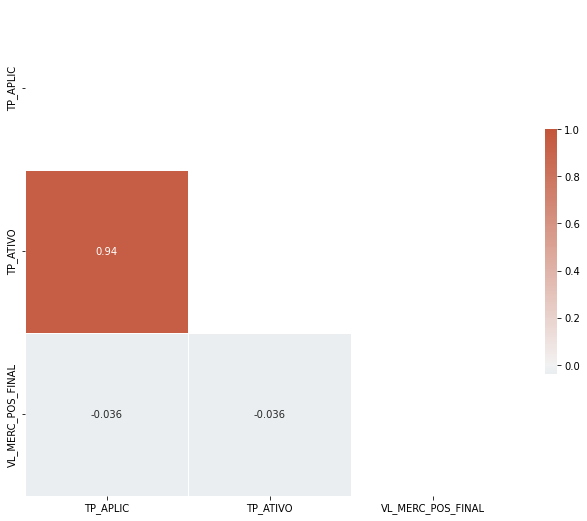

In [16]:
corr = df_s.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


A análise da correlação indica alguns pontos interessantes. São eles:
- A correlação entre o tipo de ativo e o tipo de aplicação é altíssima, próximo de 100% (94%) isso ocorre porque o tipo de aplicação define, de certa forma, a carta de ativos que um fundo pode ter. Por exemplo, um fundo de renda fixa tem que ter a maior parte de seu portifólio composta por essa classe de ativos, caso contrário, ele passa a ser categorizado de outra maneira. Então, a corrlação alta existente entre o Tipo de aplicação do fundo e o Tipo de ativo é observada no mundo real pela própria definição de composição de carteira.
- Outro ponto a ser observado é que o Valor de mercado da posição final é inversamente proporcional ao tipo de aplicação e ao tipo de ativo do fundo mesmo que os valores mínimos das correlações, pelo método que utilizei, não resultem em valores negativos, ou seja, esse valor foi encontrado pela própria natureza dos dados e não por falha na metodologia. O valor igual de correlação entre esta coluna e as demais é uma coincidência mas pode ser explicada pela elevada correlação entre as demais colunas, se a correlação entre as demais colunas fosse 100% o valor identico não seria uma coincidência e sim consequência da definição da métrica de correlação. 
- Além dessas explicações, também tem a explicação da correlação negativa entre o Valor de mercado da posição final e das demais colunas em, termos de natureza da composição de fundos de investimento, que será exposta após a apresentação de duas outras informações, o método utilizado para numeração de dados e o que cada valor numérico significa no conjunto de dados real.

__Método de numeração:__ A metodologia responsável pela enumeração dos dados de texto dispostos nas colunas Tipo de Ativo e Tipo de aplicação convertia o texto do dataset em seu índice da lista de valores únicos. Dessa forma, na coluna Tipo de Aplicação, o valor "Operações Compromissadas" era trocado por 0, "Títulos Públicos" por 1 e assim por diante, a mesma metodologia foi aplicada para a coluna Tipo de Ativo seguindo as duas listas a seguir:

In [17]:
df['TP_APLIC'].unique()

array(['Operaes Compromissadas', 'Ttulos Pblicos', 'Cotas de Fundos',
       'Cotas de fundos de investimento - Instruo N 409',
       'Cotas de fundos de renda varivel', 'DIFERENCIAL DE SWAP A PAGAR',
       'DIFERENCIAL DE SWAP A RECEBER', 'Aes', 'Debntures',
       'Mercado Futuro - Posies vendidas',
       'Brazilian Depository Receipt - BDR',
       'Certificado ou recibo de depsito de valores mobilirios',
       'Outros valores mobilirios registrados na CVM objeto de oferta pblica',
       'Mercado Futuro - Posies compradas',
       'Obrigaes por aes e outros TVM recebidos em emprstimo',
       'Aes e outros TVM cedidos em emprstimo',
       'Compras a termo a receber', 'Opes - Posies lanadas',
       'Opes - Posies titulares', 'Vendas a termo a receber',
       'Depsitos a prazo e outros ttulos de IF',
       'Ttulos de Crdito Privado', 'Ttulos ligados ao agronegcio',
       'Investimento no Exterior', 'Cotas de fundos de renda fixa',
       'Disponibilidades', 'Valores a pagar'

In [18]:
df['TP_ATIVO'].unique()


array(['Ttulo pblico federal', 'Ttulo Pblico', 'Fundos de ndice',
       'Fundo de Investimento e de Cotas', 'FI Imobilirio',
       'FI Participaes', 'FIDC', 'Cotas de fundos', 'SWAP', 'Ao ordinria',
       'Debnture simples', 'Ao preferencial', 'Futuro de DI1:DI de 1 dia',
       'BDR nvel I', 'Certificado de depsito de aes', 'Bnus de subscrio',
       'BDR no patrocinado', 'Futuro de DAP:Cupom de DI x IPCA',
       'Debnture conversvel', 'Debnture Permutvel', 'Opo de venda',
       'BDR nvel III', 'Opo de compra', 'Futuro de DDI:Cupom cambial',
       'Certificado de recebveis imobilirios', 'BDR de ETF',
       'Recibo de subscrio', 'Debnture Conversvel Permutvel',
       'Futuro de DOL:Dlar comercial', 'Futuro de WIN:Ibovespa futuro',
       'Letra Financeira', 'CDB/ RDB', 'DPGE', 'Outros',
       'Letra de Cmbio/ Letra Hipotecria/ Letra Imobiliria',
       'Nota Promissria/ Commercial Paper/ Export Note', 'CCB', 'CRA',
       'CPR', 'CCCB', 'CCI', 'NCA', 'CDCA',
       'Depository

Com isso, os valores mais altos, ou seja mais para o final das duas listas, detêm menores Valores de mercado da posição final, em comparação com os valores mais para o início da lista, de acordo com a análise de correlação realizada, assim, os fundos de debentures, simples e conversíveis, fundos futuros e fundo de ICF, em dezembro de 2021, retiveram menores valores de posição em comparação com os fundos de Operações Compromissadas, Fundos de Títulos Públicos, Títulos públicos federal, Fundos de índice, de uma forma geral. 

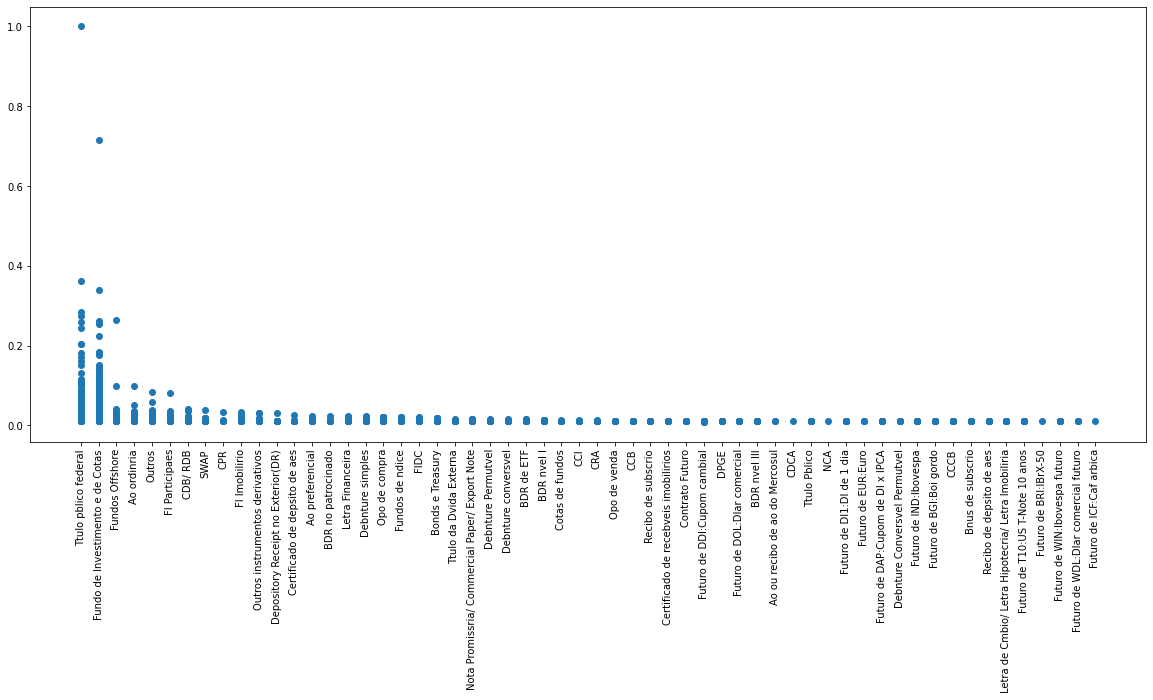

In [19]:
df_plot = df[['TP_ATIVO','VL_MERC_POS_FINAL']].dropna(how='any').sort_values('VL_MERC_POS_FINAL', ascending=False)
x = df_plot['TP_ATIVO']
y = df_plot['VL_MERC_POS_FINAL']
plt.figure(figsize=(20,8))
plt.scatter(x,y)
plt.xticks(rotation = 90);

### Clusterização

Agrupamento dos fundos de acordo com suas características

#### K - Means

Vou utilizar o método K-Means para realizar o agrupamento dos dados.

##### Preparação

Para realizar o clustering, os dados que possuem linhas com valores NaN devem ser removidas

In [20]:
df_s_cluster = df_s.dropna(how='all', axis=0)
df_s_cluster.fillna(df_s_cluster.mean(), inplace=True)
df_s_cluster = np.array(df_s_cluster)

##### Cluster

In [21]:
kmeans = KMeans(n_clusters=4)
label = kmeans.fit_predict(df_s_cluster)

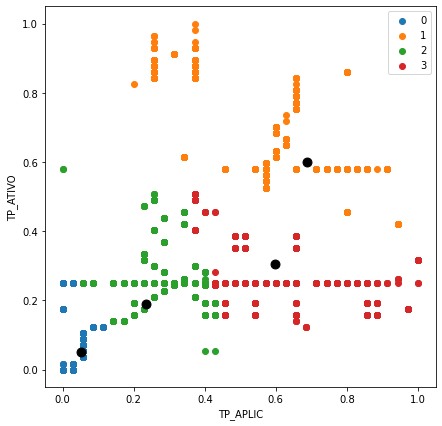

In [22]:
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(7,7))
for i in u_labels:
    plt.scatter(df_s_cluster[label == i, 0], df_s_cluster[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='black')
plt.legend()
plt.xlabel(df_s.columns.to_series()[0])
plt.ylabel(df_s.columns.to_series()[1])
plt.show()


##### Análise

Para melhor entender a lógica por trás dessa separação, em seguida o plot com a coluna Valor de mercado da posição final

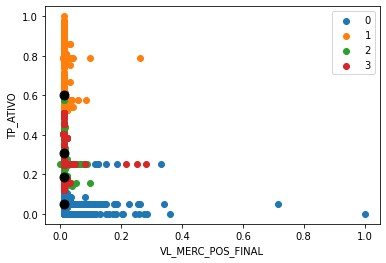

In [23]:
for i in u_labels:
    plt.scatter(df_s_cluster[label == i, 2],
                df_s_cluster[label == i, 1], label=i)
plt.scatter(centroids[:, 2], centroids[:, 1], s=80, color= 'black')
plt.legend()
plt.xlabel(df_s.columns.to_series()[2])
plt.ylabel(df_s.columns.to_series()[1])
plt.show()


A divisão dos clusters é mais evidenciada pela relação entre as colunas Tipo de Ativo e Tipo de Aplicação. Isso acontece em virtude da maior distribuição dos valores dessas duas colunas. Entretanto, o fato de as colunas com valores mais elevados de ambas as colunas estarem nos mesmos grupos é explicado pela alta correlação entre ambas as colunas.

#### Os grupos são:

##### pré-processamento

In [24]:
df_grupos = df[['TP_APLIC', 'TP_ATIVO', 'VL_MERC_POS_FINAL']]
df_grupos.dropna(how='all', inplace=True)
df_grupos['VL_MERC_POS_FINAL'].fillna(df_grupos['VL_MERC_POS_FINAL'].mean(),axis=0, inplace=True)
df_grupos['TP_ATIVO'].fillna('outros', axis=0, inplace=True)
df_grupos['TP_APLIC'].fillna('outros', axis=0, inplace=True)
df_grupos['label'] = label


C:\Users\isabe\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\isabe\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
<ipython-input-24-60b55358aef2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [25]:
grupo1 = agrupar(df_grupos, 'label', 0, 'VL_MERC_POS_FINAL', 'label')
grupo2 = agrupar(df_grupos, 'label', 1, 'VL_MERC_POS_FINAL', 'label')
grupo3 = agrupar(df_grupos, 'label', 2, 'VL_MERC_POS_FINAL', 'label')
grupo4 = agrupar(df_grupos, 'label', 3, 'VL_MERC_POS_FINAL', 'label')
g1wc = agruparwc(grupo1)
g2wc = agruparwc(grupo2)
g3wc = agruparwc(grupo3)
g4wc = agruparwc(grupo4)
f1 = wc(g1wc)
f2 = wc(g2wc)
f3 = wc(g3wc)
f4 = wc(g4wc)


##### Grupo 1

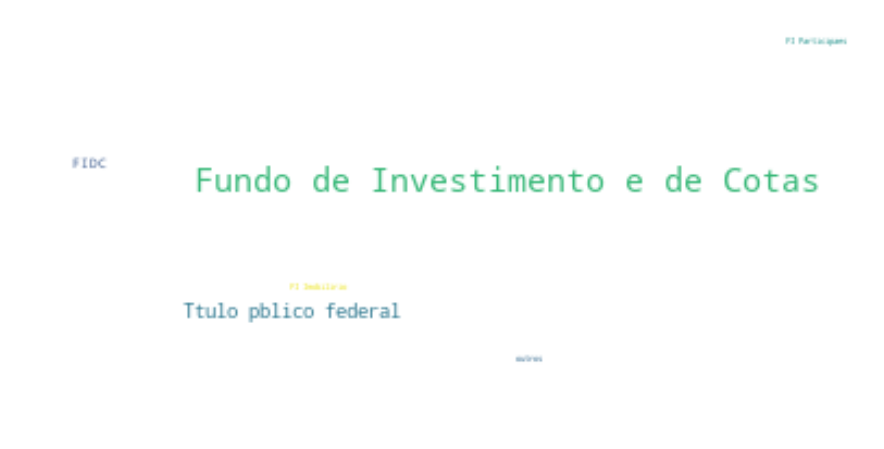

In [32]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=f1)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


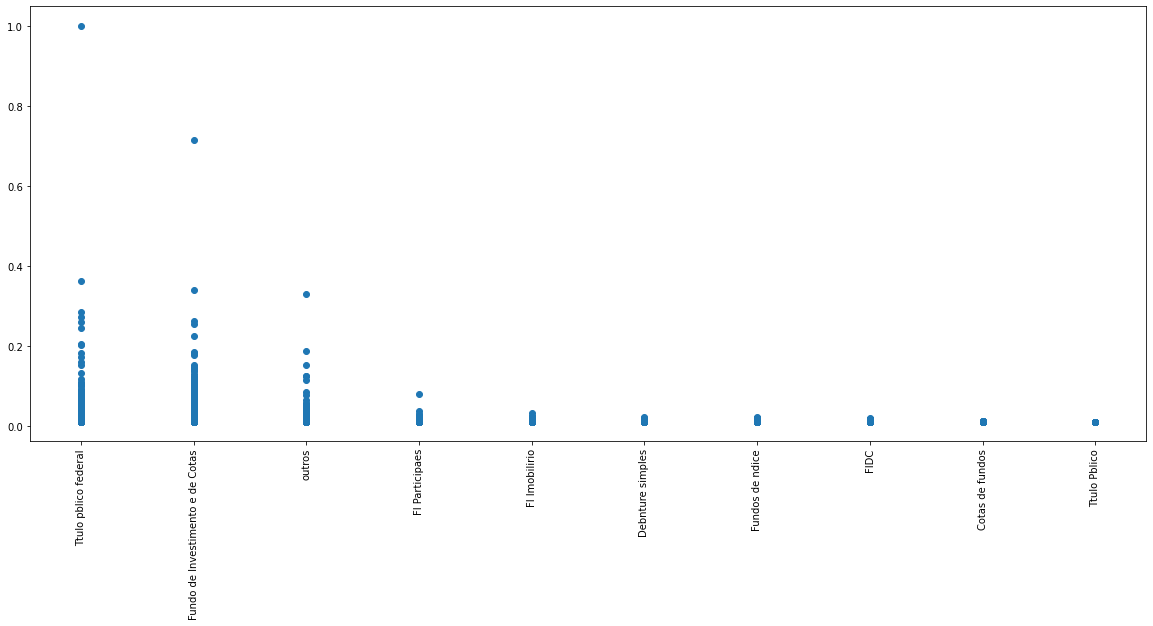

In [26]:
x = grupo1['TP_ATIVO']
y = grupo1['VL_MERC_POS_FINAL']
plt.figure(figsize=(20, 8))
plt.scatter(x, y)
plt.xticks(rotation=90);

##### Grupo 2

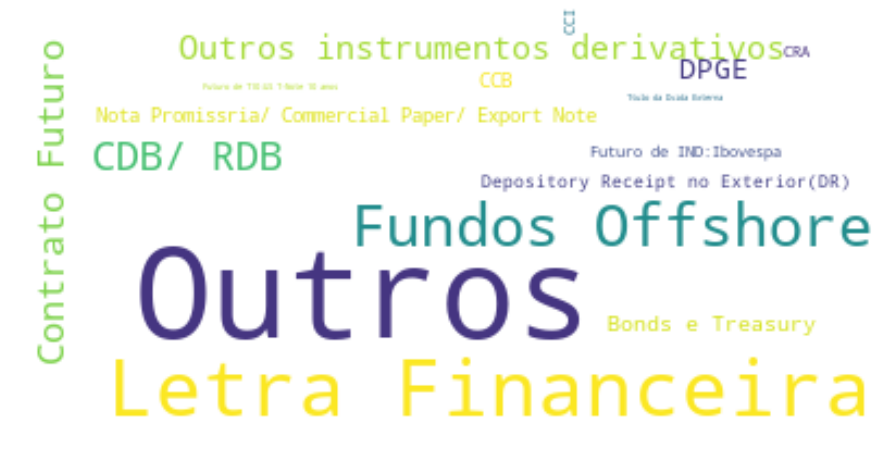

In [31]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=f2)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


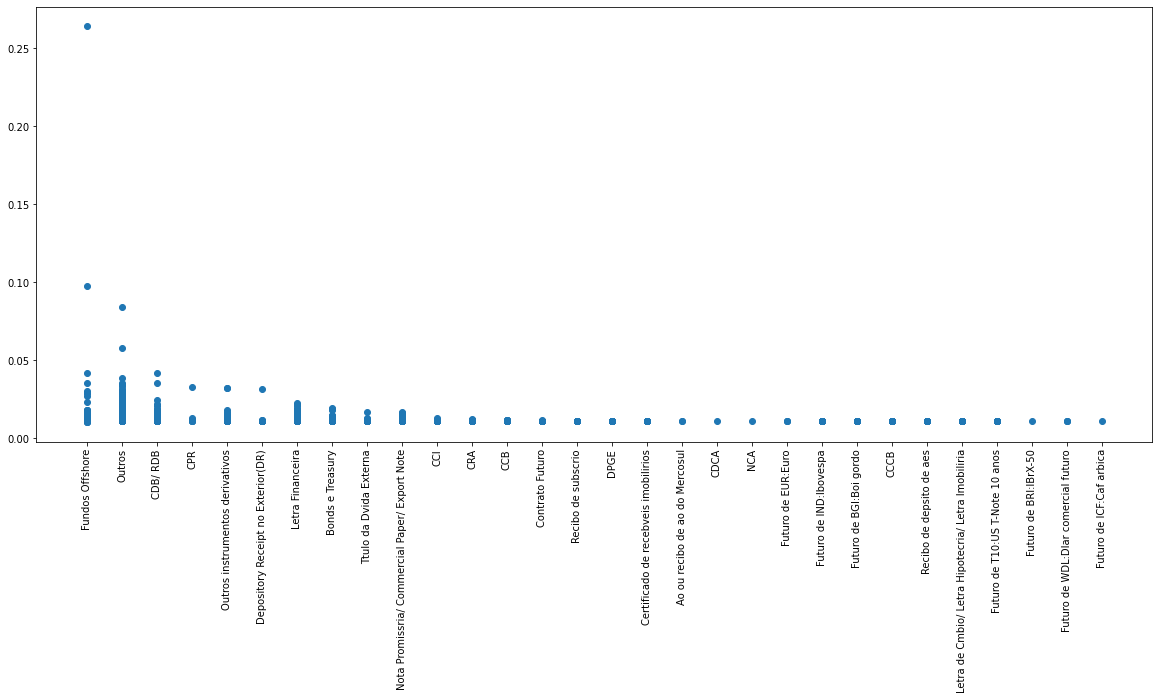

In [27]:
x = grupo2['TP_ATIVO']
y = grupo2['VL_MERC_POS_FINAL']
plt.figure(figsize=(20, 8))
plt.scatter(x, y)
plt.xticks(rotation=90);


##### Grupo 3

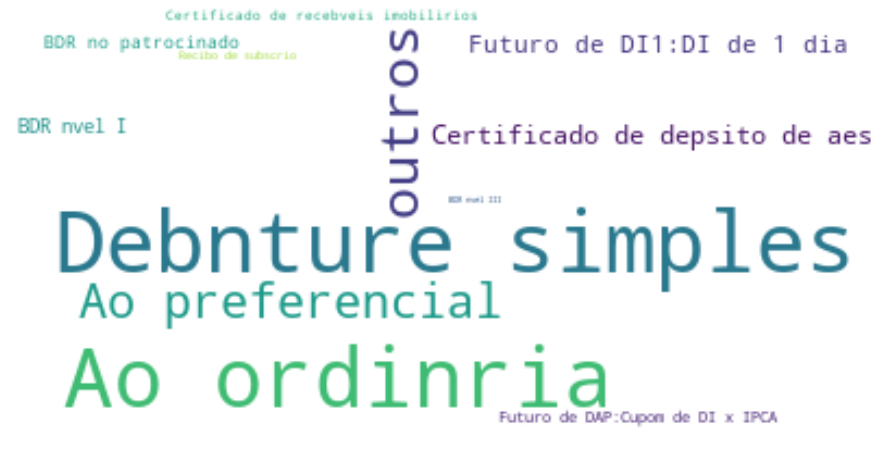

In [33]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=f3)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


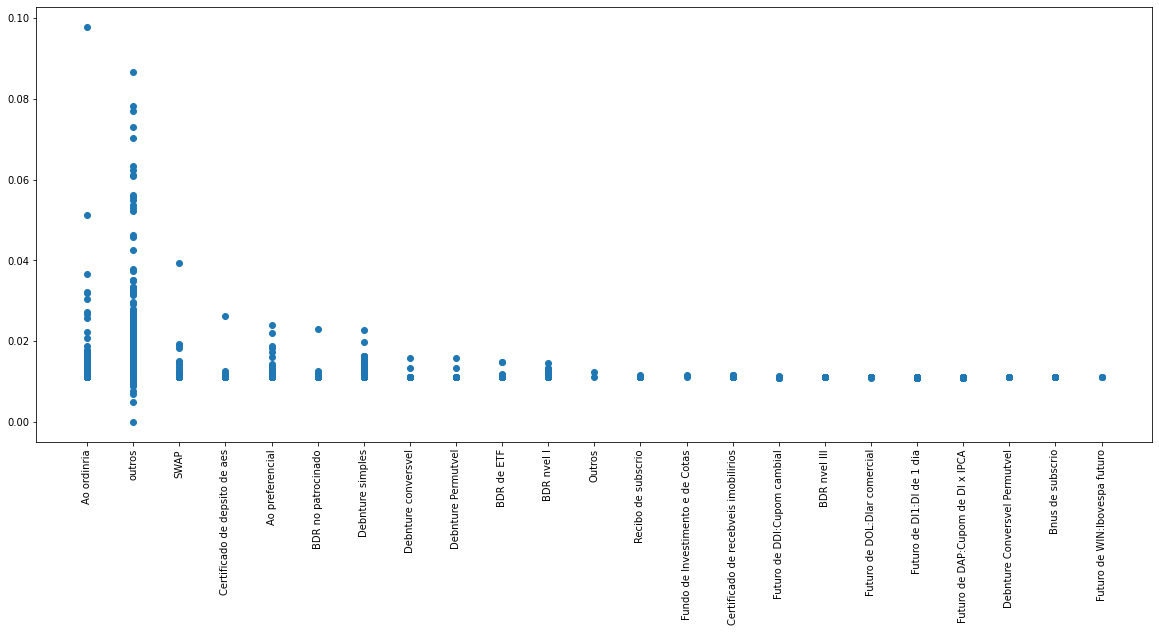

In [28]:
x = grupo3['TP_ATIVO']
y = grupo3['VL_MERC_POS_FINAL']
plt.figure(figsize=(20, 8))
plt.scatter(x, y)
plt.xticks(rotation=90);

##### Grupo 4

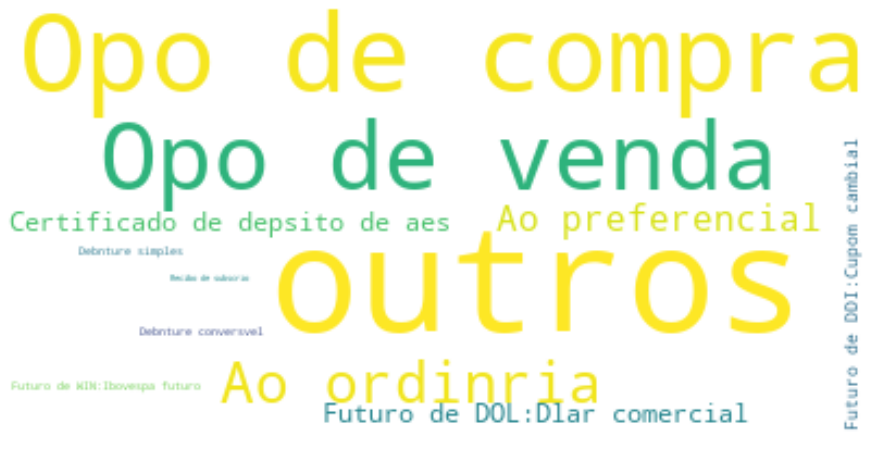

In [34]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=f4)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


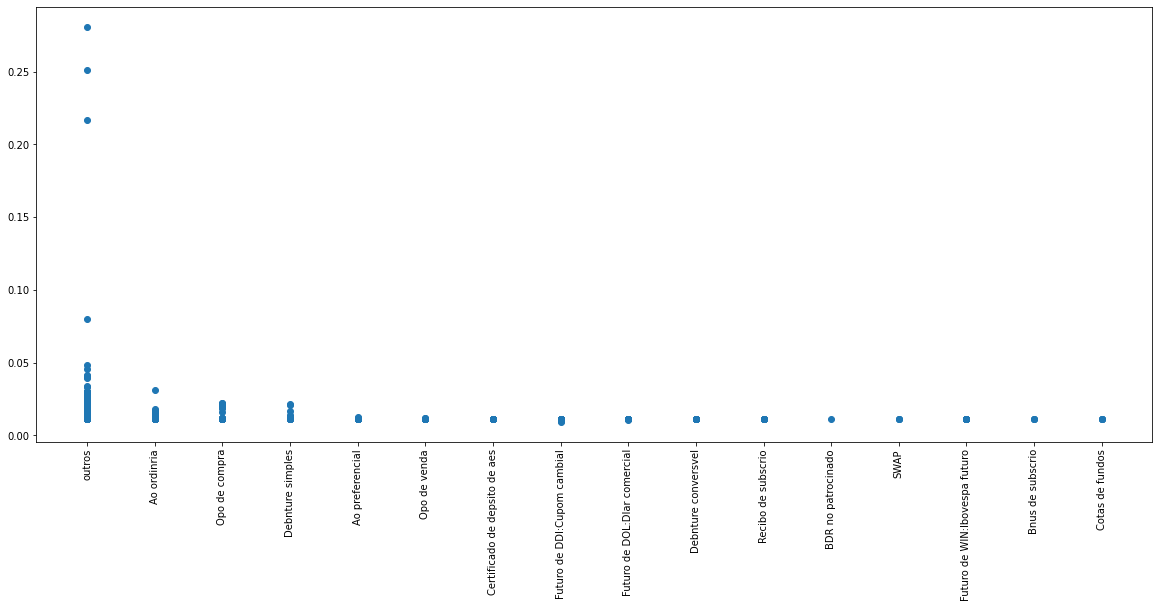

In [29]:
x = grupo4['TP_ATIVO']
y = grupo4['VL_MERC_POS_FINAL']
plt.figure(figsize=(20, 8))
plt.scatter(x, y)
plt.xticks(rotation=90);